In [1]:
import pandas as pd
import numpy as np
import math
from random import choices
from datetime import datetime
import statistics

In [2]:
import devanalyst.simulation.statics as S_
import devanalyst.simulation.GenerateTimecards as timecard
from devanalyst.simulation.GenerateTimecards import WorkAssignments
from devanalyst.simulation.simulationModels import BalancedAllocationModel, GreedyAllocationModel, ModelsConfig, DefaultCostModel

importing Jupyter notebook from c:\alex\code\labs\devanalyst\devanalyst\simulation\statics.ipynb
importing Jupyter notebook from c:\alex\code\labs\devanalyst\devanalyst\simulation\GenerateTimecards.ipynb
importing Jupyter notebook from c:\alex\code\labs\devanalyst\devanalyst\simulation\simulationModels.ipynb


In [3]:
import devanalyst.simulation.tests.test_utils as tu_

importing Jupyter notebook from c:\alex\code\labs\devanalyst\devanalyst\simulation\tests\test_utils.ipynb


<h2>test_greedyAllocationLogs</h2>

In [4]:
# Implement test logic, and run it

#Test logic
def test_greedyAllocationLogs():    
    output = {}
    RELEASE_DURATION = 125
    SPRINT_DURATION = 10

    # Configure models
    model = GreedyAllocationModel(SPRINT_DURATION) 
    modelsConfig = ModelsConfig([], [], model)
    modelsConfig.random.reset(271)

    teams_df, stories_df, teamsRepo, storiesRepo, ticketsRepo = tu_.initTestData(tu_.DEV_DF, tu_.PM_DF, \
                                                                             RELEASE_DURATION, SPRINT_DURATION, modelsConfig)

    # Select a team
    teamId = teams_df['Scrum Team'][0].teamId
       
    work = WorkAssignments(teamId, teamsRepo, storiesRepo, sprint=1)
    work = model.allocate(work, modelsConfig)
    
    log_df = model.buildLog_df('Sprint 1 QA')
        
    output['Logs'] = log_df
    return output

# Run the test
test_greedyAllocationLogs_ACTUAL = test_greedyAllocationLogs()

In [5]:
# Uncomment to update expected output to match the actual one

# Helper method
def create_greedyAllocationLogs_EXPECTED():
    tu_.createExpectedOutput(test_greedyAllocationLogs_ACTUAL['Logs'],    'simm.test_greedyAllocationLogs')

# Uncomment to update expected output to match the actual one, and then put the comment back
#create_greedyAllocationLogs_EXPECTED()

In [6]:
# Load expected output, update the EXPECTED and ACTUAL dictionaries, and check test is OK
list_cols = ['Initial Data - CURRENT_SPRINT', 'Final Data - CURRENT_SPRINT', 'Remaining Data - CURRENT_SPRINT',\
             'Initial Data - NEXT_SPRINT', 'Final Data - NEXT_SPRINT', 'Remaining Data - NEXT_SPRINT'
            ]

test_greedyAllocationLogs_EXPECTED = {}

test_greedyAllocationLogs_EXPECTED['Logs']      = tu_.loadExpectedOutput('simm.test_greedyAllocationLogs', list_cols)

# Rounding inaccuracies in saving and loading CSV will create an artificial mismatch between ACTUAL and EXPECTED
# So round EXPECTED and ACTUAL to 6 decimal places for sensitive fields (any float)
sensitive_fields = ['Initial Mean - CURRENT_SPRINT', 'Final Mean - CURRENT_SPRINT', 'Remaining Mean - CURRENT_SPRINT', \
                    'Initial Distance - CURRENT_SPRINT', 'Final Distance - CURRENT_SPRINT', 'Remaining Distance - CURRENT_SPRINT',\
                    'Initial Mean - NEXT_SPRINT', 'Final Mean - NEXT_SPRINT', 'Remaining Mean - NEXT_SPRINT', \
                    'Initial Distance - NEXT_SPRINT', 'Final Distance - NEXT_SPRINT', 'Remaining Distance - NEXT_SPRINT'              
                   ]
testlets = ['Logs']
for field in sensitive_fields:
    for testlet in testlets:
        rounded = test_greedyAllocationLogs_EXPECTED[testlet][field].apply(lambda x: round(x, 6)) # Round to 6 decimal places
        test_greedyAllocationLogs_EXPECTED[testlet][field] = rounded
        rounded = test_greedyAllocationLogs_ACTUAL[testlet][field].apply(lambda x: round(x, 6)) # Round to 6 decimal places
        test_greedyAllocationLogs_ACTUAL[testlet][field] = rounded

tu_.EXPECTED['simm.test_greedyAllocationLogs']      = test_greedyAllocationLogs_EXPECTED['Logs']

tu_.ACTUAL['simm.test_greedyAllocationLogs']        = test_greedyAllocationLogs_ACTUAL['Logs']

tu_.testOK('simm.test_greedyAllocationLogs')

True

In [7]:
test_greedyAllocationLogs_ACTUAL['Logs'][:5]

,Title,Cycle,Initial Size - CURRENT_SPRINT,Initial Mean - CURRENT_SPRINT,Initial Distance - CURRENT_SPRINT,Initial Data - CURRENT_SPRINT,Remaining Size - CURRENT_SPRINT,Remaining Mean - CURRENT_SPRINT,Remaining Distance - CURRENT_SPRINT,Remaining Data - CURRENT_SPRINT,...,Initial Data - NEXT_SPRINT,Remaining Size - NEXT_SPRINT,Remaining Mean - NEXT_SPRINT,Remaining Distance - NEXT_SPRINT,Remaining Data - NEXT_SPRINT,Final Size - NEXT_SPRINT,Final Mean - NEXT_SPRINT,Final Distance - NEXT_SPRINT,Final Data - NEXT_SPRINT,Bins - NEXT_SPRINT
0,Sprint 1 QA,0,0,0.000000,54.092513,[],185,5.286486,7.681146,"[10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10....",...,[],0,0,0,[],0,0,0,[],10
1,Sprint 1 QA,1,1,2.000000,53.730811,[2.0],184,5.304348,6.928203,"[10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10....",...,[],0,0,0,[],0,0,0,[],10
2,Sprint 1 QA,2,2,4.000000,53.441557,"[6.0, 2.0]",183,5.300546,6.855655,"[10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10....",...,[],0,0,0,[],0,0,0,[],10
3,Sprint 1 QA,3,3,3.333333,53.094256,"[2.0, 2.0, 6.0]",182,5.318681,6.164414,"[10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10....",...,[],0,0,0,[],0,0,0,[],10
4,Sprint 1 QA,4,4,3.250000,52.744668,"[2.0, 2.0, 3.0, 6.0]",181,5.331492,5.916080,"[10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10....",...,[],0,0,0,[],0,0,0,[],10


In [8]:
test_greedyAllocationLogs_EXPECTED['Logs'][:5]

,Title,Cycle,Initial Size - CURRENT_SPRINT,Initial Mean - CURRENT_SPRINT,Initial Distance - CURRENT_SPRINT,Initial Data - CURRENT_SPRINT,Remaining Size - CURRENT_SPRINT,Remaining Mean - CURRENT_SPRINT,Remaining Distance - CURRENT_SPRINT,Remaining Data - CURRENT_SPRINT,...,Initial Data - NEXT_SPRINT,Remaining Size - NEXT_SPRINT,Remaining Mean - NEXT_SPRINT,Remaining Distance - NEXT_SPRINT,Remaining Data - NEXT_SPRINT,Final Size - NEXT_SPRINT,Final Mean - NEXT_SPRINT,Final Distance - NEXT_SPRINT,Final Data - NEXT_SPRINT,Bins - NEXT_SPRINT
0,Sprint 1 QA,0,0,0.000000,54.092513,[],185,5.286486,7.681146,"[10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10....",...,[],0,0,0,[],0,0,0,[],10
1,Sprint 1 QA,1,1,2.000000,53.730811,[2.0],184,5.304348,6.928203,"[10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10....",...,[],0,0,0,[],0,0,0,[],10
2,Sprint 1 QA,2,2,4.000000,53.441557,"[6.0, 2.0]",183,5.300546,6.855655,"[10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10....",...,[],0,0,0,[],0,0,0,[],10
3,Sprint 1 QA,3,3,3.333333,53.094256,"[2.0, 2.0, 6.0]",182,5.318681,6.164414,"[10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10....",...,[],0,0,0,[],0,0,0,[],10
4,Sprint 1 QA,4,4,3.250000,52.744668,"[2.0, 2.0, 3.0, 6.0]",181,5.331492,5.916080,"[10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10....",...,[],0,0,0,[],0,0,0,[],10


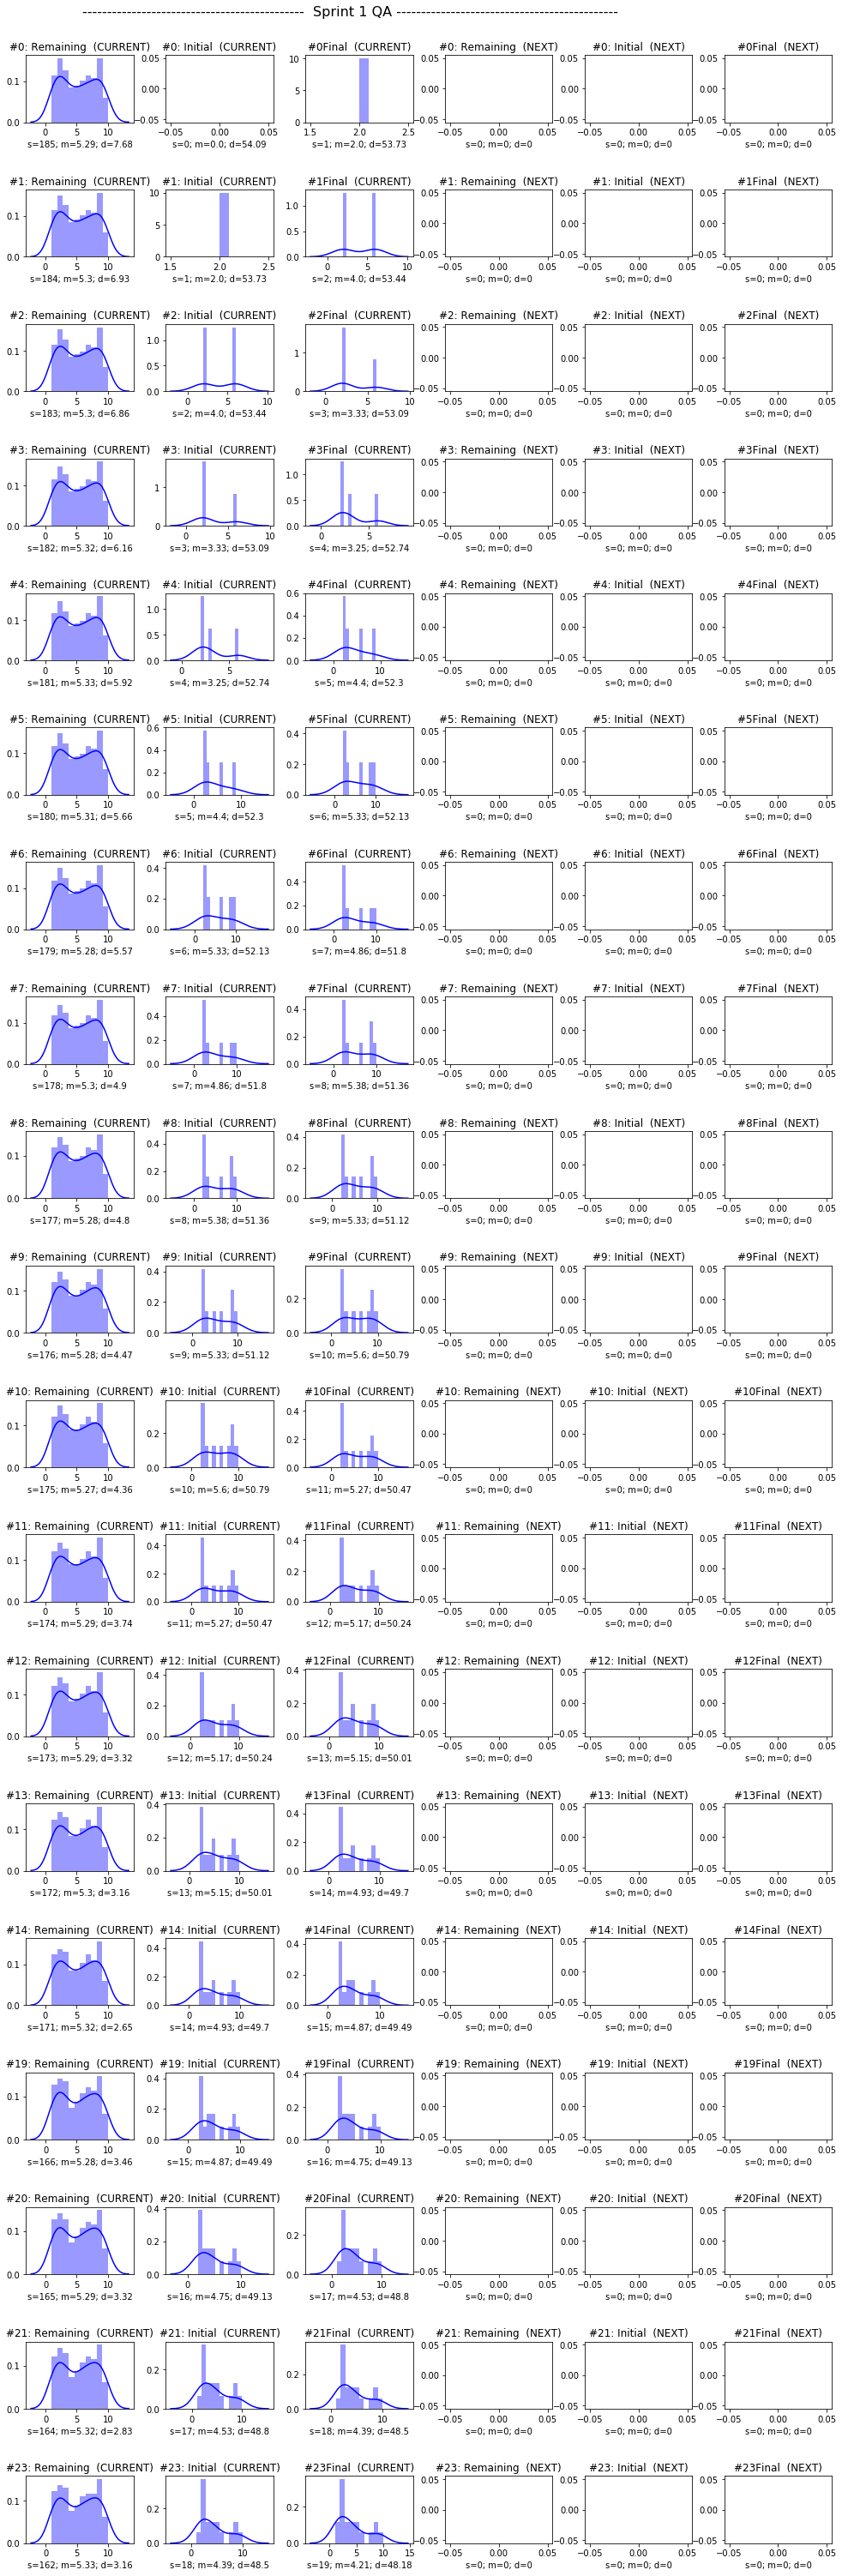

In [25]:
# Uncomment to interactively visualize the logs, and then comment again once interactive analysis is done. Commenting these
# lines after interactive analysis is completed is required as test harness can't load these visualiations
# libraries so leaving this uncommented will crash the entire test harness.
#import devanalyst.simulation.visualizations.simm_visuals as simm_visuals
#simm_visuals.renderLog(test_greedyAllocationLogs_ACTUAL['Logs'],'b')

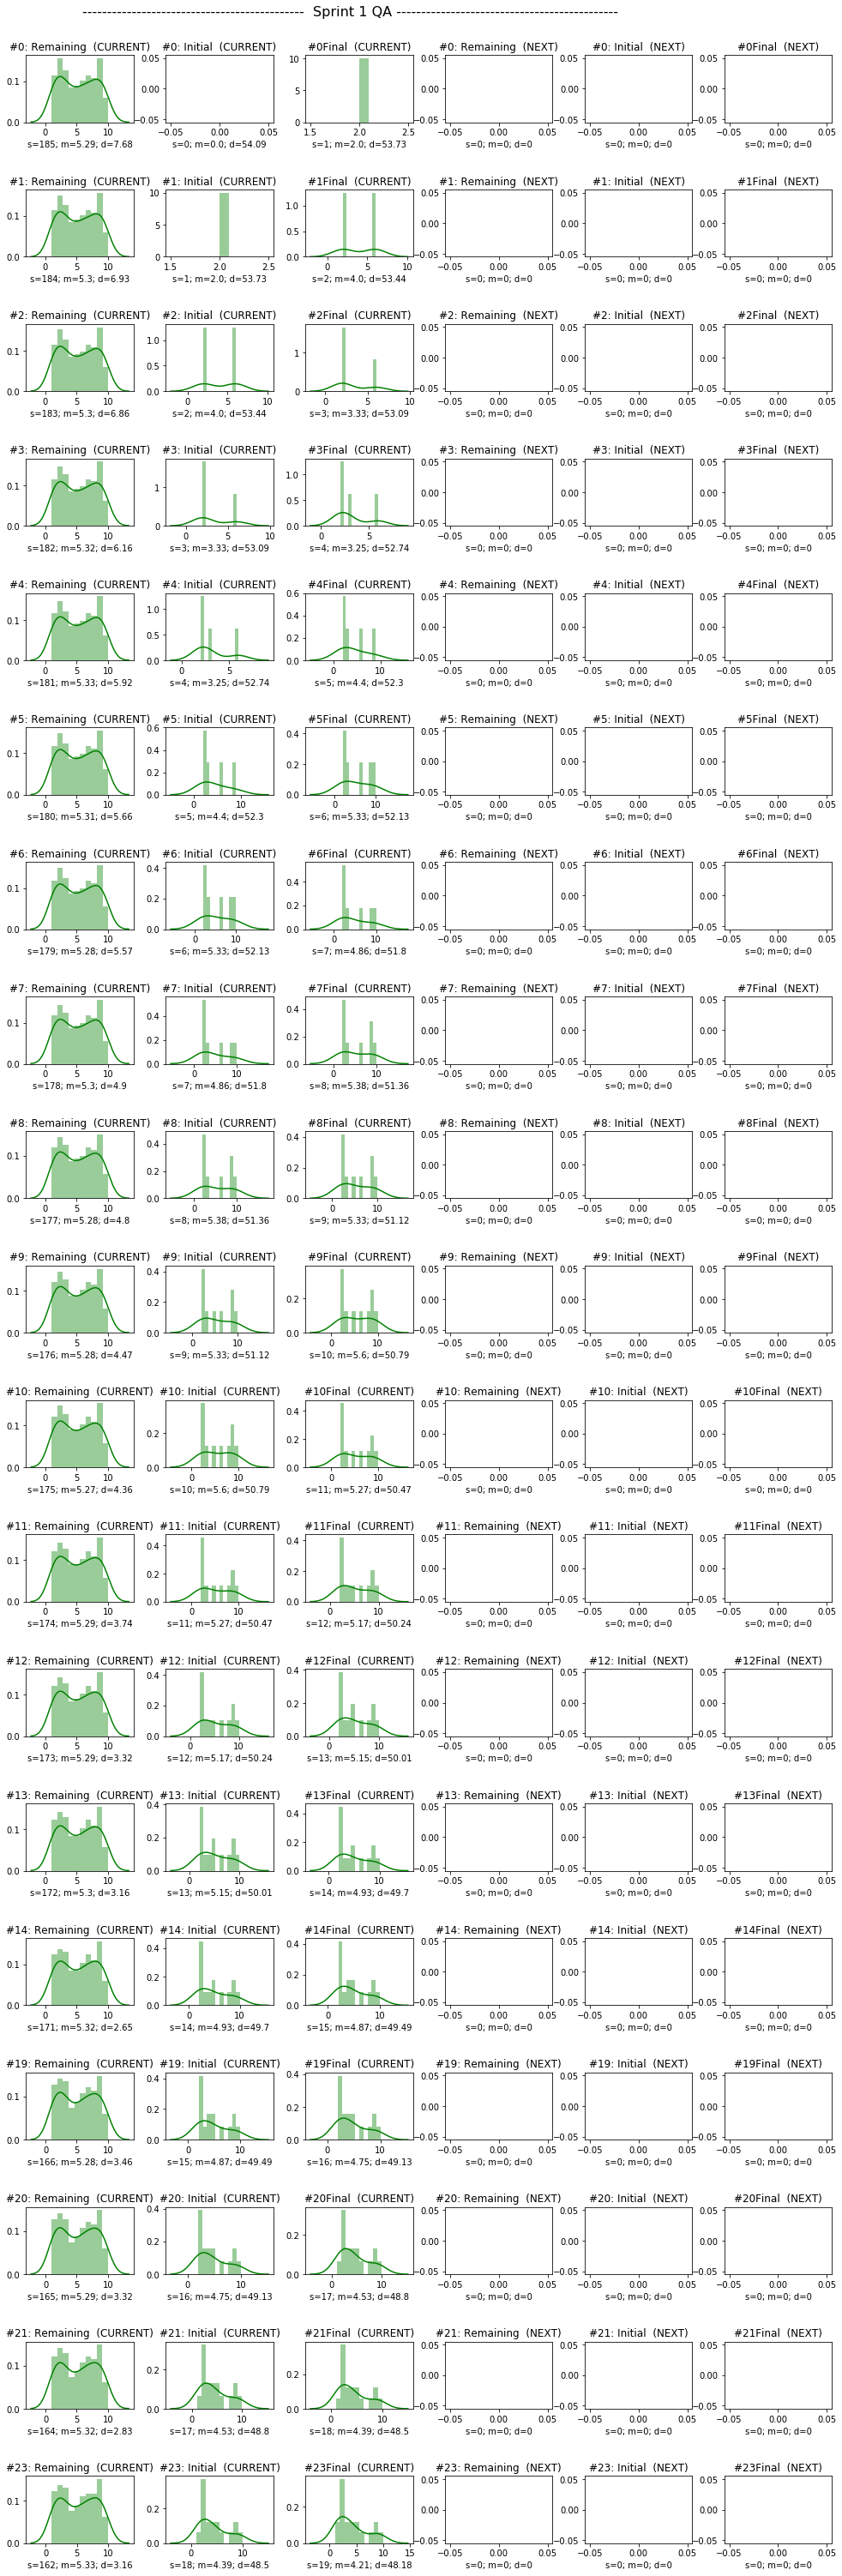

In [10]:
# Uncomment to interactively visualize the logs, and then comment again once interactive analysis is done. Commenting these
# lines after interactive analysis is completed is required as test harness can't load these visualiations
# libraries so leaving this uncommented will crash the entire test harness.
#import devanalyst.simulation.visualizations.simm_visuals as simm_visuals
#simm_visuals.renderLog(test_greedyAllocationLogs_EXPECTED['Logs'],'g')

<h1>test_greedyAllocation</h1>

In [11]:
# Implement test logic, and run it

#Test logic
def test_greedyAllocation():    
    output = {}
    RELEASE_DURATION = 125
    SPRINT_DURATION = 10

    # Configure models
    model = GreedyAllocationModel(SPRINT_DURATION) 
    modelsConfig = ModelsConfig([], [], model)
    modelsConfig.random.reset(271)

    teams_df, stories_df, teamsRepo, storiesRepo, ticketsRepo = tu_.initTestData(tu_.DEV_DF, tu_.PM_DF, \
                                                                             RELEASE_DURATION, SPRINT_DURATION, modelsConfig)

    # Select a team
    teamId = teams_df['Scrum Team'][0].teamId
    
    # Choose what to work on at the start of a sprint.
    SPRINT_DURATION = 10

   
    work = WorkAssignments(teamId, teamsRepo, storiesRepo, sprint=1)

    work = model.allocate(work, modelsConfig)
    
    committed_df = work.committedTime(SPRINT_DURATION)
    tasks_df = work.committedTasks()
        
    output['Committed'] = committed_df
    output['Tasks'] = tasks_df
    return output

# Run the test
test_greedyAllocation_ACTUAL = test_greedyAllocation()

In [12]:
# Uncomment to update expected output to match the actual one

# Helper method
def create_greedyAllocation_EXPECTED():
    tu_.createExpectedOutput(test_greedyAllocation_ACTUAL['Committed'],    'simm.test_greedyAllocation.Committed')
    tu_.createExpectedOutput(test_greedyAllocation_ACTUAL['Tasks'],        'simm.test_greedyAllocation.Tasks')

# Uncomment to update expected output to match the actual one, and then put the comment back
#create_greedyAllocation_EXPECTED()

In [13]:
# Load expected output, update the EXPECTED and ACTUAL dictionaries, and check test is OK
test_greedyAllocation_EXPECTED = {}

test_greedyAllocation_EXPECTED['Committed']      = tu_.loadExpectedOutput('simm.test_greedyAllocation.Committed')
test_greedyAllocation_EXPECTED['Tasks']          = tu_.loadExpectedOutput('simm.test_greedyAllocation.Tasks')

# Rounding inaccuracies in saving and loading CSV will create an artificial mismatch between ACTUAL and EXPECTED
# So round EXPECTED and ACTUAL to 6 decimal places for sensitive fields (any float)
sensitive_fields = ['Rejects (days)', 'Debugging (days)', 'Implementation (days)', 'Bandwidth',\
                    'NEXT SPRINT (days)', 'NEXT SPRINT Bandwidth']
testlets = ['Committed']
for field in sensitive_fields:
    for testlet in testlets:
        rounded = test_greedyAllocation_EXPECTED[testlet][field].apply(lambda x: round(x, 6)) # Round to 6 decimal places
        test_greedyAllocation_EXPECTED[testlet][field] = rounded
        rounded = test_greedyAllocation_ACTUAL[testlet][field].apply(lambda x: round(x, 6)) # Round to 6 decimal places
        test_greedyAllocation_ACTUAL[testlet][field] = rounded
sensitive_fields = ['Original Estimate', 'Effort Spent', 'Effort Remaining', 'Percent Achieved']
testlets = ['Tasks']
for field in sensitive_fields:
    for testlet in testlets:
        rounded = test_greedyAllocation_EXPECTED[testlet][field].apply(lambda x: round(x, 6)) # Round to 6 decimal places
        test_greedyAllocation_EXPECTED[testlet][field] = rounded
        rounded = test_greedyAllocation_ACTUAL[testlet][field].apply(lambda x: round(x, 6)) # Round to 6 decimal places
        test_greedyAllocation_ACTUAL[testlet][field] = rounded

tu_.EXPECTED['simm.test_greedyAllocation.Committed']      = test_greedyAllocation_EXPECTED['Committed']
tu_.EXPECTED['simm.test_greedyAllocation.Tasks']          = test_greedyAllocation_EXPECTED['Tasks']

tu_.ACTUAL['simm.test_greedyAllocation.Committed']        = test_greedyAllocation_ACTUAL['Committed']
tu_.ACTUAL['simm.test_greedyAllocation.Tasks']            = test_greedyAllocation_ACTUAL['Tasks']

tu_.testOK('simm.test_greedyAllocation.Committed'), \
tu_.testOK('simm.test_greedyAllocation.Tasks'), \

(True, True)

In [14]:
test_greedyAllocation_ACTUAL['Committed']

,Developer,Rejects (days),Rejects (#),Debugging (days),Debugging (#),Implementation (days),Implementation (#),Bandwidth,NEXT SPRINT (days),NEXT SPRINT (#),NEXT SPRINT Bandwidth
0,Anton Easterday,0.0,0,0.0,0,10.0,4,0.0,0.0,0,10.0
1,Beau Hockensmith,0.0,0,0.0,0,10.0,1,0.0,0.0,0,10.0
2,Bruno Studley,0.0,0,0.0,0,10.0,3,0.0,0.0,0,10.0
3,Craig Garlitz,0.0,0,0.0,0,10.0,2,0.0,0.0,0,10.0
4,Francisco Hoppe,0.0,0,0.0,0,10.0,2,0.0,0.0,0,10.0
5,Glenna Mcghie,0.0,0,0.0,0,10.0,2,0.0,0.0,0,10.0
6,Gregorio Darr,0.0,0,0.0,0,10.0,3,0.0,0.0,0,10.0
7,Heriberto Martini,0.0,0,0.0,0,10.0,2,0.0,0.0,0,10.0
8,OWNER_TBD,0.0,0,0.0,0,898.0,166,NaN,0.0,0,0.0


In [15]:
test_greedyAllocation_EXPECTED['Committed']

,Developer,Rejects (days),Rejects (#),Debugging (days),Debugging (#),Implementation (days),Implementation (#),Bandwidth,NEXT SPRINT (days),NEXT SPRINT (#),NEXT SPRINT Bandwidth
0,Anton Easterday,0.0,0,0.0,0,10.0,4,0.0,0.0,0,10.0
1,Beau Hockensmith,0.0,0,0.0,0,10.0,1,0.0,0.0,0,10.0
2,Bruno Studley,0.0,0,0.0,0,10.0,3,0.0,0.0,0,10.0
3,Craig Garlitz,0.0,0,0.0,0,10.0,2,0.0,0.0,0,10.0
4,Francisco Hoppe,0.0,0,0.0,0,10.0,2,0.0,0.0,0,10.0
5,Glenna Mcghie,0.0,0,0.0,0,10.0,2,0.0,0.0,0,10.0
6,Gregorio Darr,0.0,0,0.0,0,10.0,3,0.0,0.0,0,10.0
7,Heriberto Martini,0.0,0,0.0,0,10.0,2,0.0,0.0,0,10.0
8,OWNER_TBD,0.0,0,0.0,0,898.0,166,NaN,0.0,0,0.0


In [16]:
test_greedyAllocation_ACTUAL['Tasks']

,Owner,Task Type,User Story Id,Planned for Sprint,Original Estimate,Bucket,Effort Spent,Effort Remaining,Percent Achieved
0,Anton Easterday,UNFINISHED_STORIES,UserStory #151,1,2.0,CURRENT_SPRINT,0.0,2.0,0.0
1,Anton Easterday,UNFINISHED_STORIES,UserStory #97,1,2.0,CURRENT_SPRINT,0.0,2.0,0.0
2,Anton Easterday,UNFINISHED_STORIES,UserStory #58,1,4.0,CURRENT_SPRINT,0.0,4.0,0.0
3,Anton Easterday,UNFINISHED_STORIES,UserStory #83,1,2.0,CURRENT_SPRINT,0.0,2.0,0.0
4,Beau Hockensmith,UNFINISHED_STORIES,UserStory #1,1,10.0,CURRENT_SPRINT,0.0,10.0,0.0
5,Bruno Studley,UNFINISHED_STORIES,UserStory #77,1,3.0,CURRENT_SPRINT,0.0,3.0,0.0
6,Bruno Studley,UNFINISHED_STORIES,UserStory #137,1,2.0,CURRENT_SPRINT,0.0,2.0,0.0
7,Bruno Studley,UNFINISHED_STORIES,UserStory #52,1,5.0,CURRENT_SPRINT,0.0,5.0,0.0
8,Craig Garlitz,UNFINISHED_STORIES,UserStory #143,1,9.0,CURRENT_SPRINT,0.0,9.0,0.0
9,Craig Garlitz,UNFINISHED_STORIES,UserStory #75,1,1.0,CURRENT_SPRINT,0.0,1.0,0.0


In [17]:
test_greedyAllocation_EXPECTED['Tasks']

,Owner,Task Type,User Story Id,Planned for Sprint,Original Estimate,Bucket,Effort Spent,Effort Remaining,Percent Achieved
0,Anton Easterday,UNFINISHED_STORIES,UserStory #151,1,2.0,CURRENT_SPRINT,0.0,2.0,0.0
1,Anton Easterday,UNFINISHED_STORIES,UserStory #97,1,2.0,CURRENT_SPRINT,0.0,2.0,0.0
2,Anton Easterday,UNFINISHED_STORIES,UserStory #58,1,4.0,CURRENT_SPRINT,0.0,4.0,0.0
3,Anton Easterday,UNFINISHED_STORIES,UserStory #83,1,2.0,CURRENT_SPRINT,0.0,2.0,0.0
4,Beau Hockensmith,UNFINISHED_STORIES,UserStory #1,1,10.0,CURRENT_SPRINT,0.0,10.0,0.0
5,Bruno Studley,UNFINISHED_STORIES,UserStory #77,1,3.0,CURRENT_SPRINT,0.0,3.0,0.0
6,Bruno Studley,UNFINISHED_STORIES,UserStory #137,1,2.0,CURRENT_SPRINT,0.0,2.0,0.0
7,Bruno Studley,UNFINISHED_STORIES,UserStory #52,1,5.0,CURRENT_SPRINT,0.0,5.0,0.0
8,Craig Garlitz,UNFINISHED_STORIES,UserStory #143,1,9.0,CURRENT_SPRINT,0.0,9.0,0.0
9,Craig Garlitz,UNFINISHED_STORIES,UserStory #75,1,1.0,CURRENT_SPRINT,0.0,1.0,0.0


<h1>test_balancedAllocation</h1>

In [18]:
# Implement test logic, and run it

#Test logic
def test_balancedAllocation():    
    output = {}
    RELEASE_DURATION = 125
    SPRINT_DURATION = 10

    # Configure models
    model = BalancedAllocationModel(SPRINT_DURATION) 
    modelsConfig = ModelsConfig([], [], model)
    modelsConfig.random.reset(271)

    teams_df, stories_df, teamsRepo, storiesRepo, ticketsRepo = tu_.initTestData(tu_.DEV_DF, tu_.PM_DF, \
                                                                             RELEASE_DURATION, SPRINT_DURATION, modelsConfig)

    # Select a team
    teamId = teams_df['Scrum Team'][0].teamId
    
    # Choose what to work on at the start of a sprint.
    SPRINT_DURATION = 10

   
    work = WorkAssignments(teamId, teamsRepo, storiesRepo, sprint=1)

    work = model.allocate(work, modelsConfig)
    
    committed_df = work.committedTime(SPRINT_DURATION)
    tasks_df = work.committedTasks()
        
    output['Committed'] = committed_df
    output['Tasks'] = tasks_df
    return output, work

# Run the test
test_balancedAllocation_ACTUAL, work = test_balancedAllocation()

In [19]:
# Uncomment to update expected output to match the actual one

# Helper method
def create_balancedAllocation_EXPECTED():
    tu_.createExpectedOutput(test_balancedAllocation_ACTUAL['Committed'],    'simm.test_balancedAllocation.Committed')
    tu_.createExpectedOutput(test_balancedAllocation_ACTUAL['Tasks'],        'simm.test_balancedAllocation.Tasks')

# Uncomment to update expected output to match the actual one, and then put the comment back
#create_balancedAllocation_EXPECTED()

In [20]:
# Load expected output, update the EXPECTED and ACTUAL dictionaries, and check test is OK
test_balancedAllocation_EXPECTED = {}

test_balancedAllocation_EXPECTED['Committed']      = tu_.loadExpectedOutput('simm.test_balancedAllocation.Committed')
test_balancedAllocation_EXPECTED['Tasks']          = tu_.loadExpectedOutput('simm.test_balancedAllocation.Tasks')

# Rounding inaccuracies in saving and loading CSV will create an artificial mismatch between ACTUAL and EXPECTED
# So round EXPECTED and ACTUAL to 6 decimal places for sensitive fields (any float)
sensitive_fields = ['Rejects (days)', 'Debugging (days)', 'Implementation (days)', 'Bandwidth',\
                    'NEXT SPRINT (days)', 'NEXT SPRINT Bandwidth']
testlets = ['Committed']
for field in sensitive_fields:
    for testlet in testlets:
        rounded = test_balancedAllocation_EXPECTED[testlet][field].apply(lambda x: round(x, 6)) # Round to 6 decimal places
        test_balancedAllocation_EXPECTED[testlet][field] = rounded
        rounded = test_balancedAllocation_ACTUAL[testlet][field].apply(lambda x: round(x, 6)) # Round to 6 decimal places
        test_balancedAllocation_ACTUAL[testlet][field] = rounded
sensitive_fields = ['Original Estimate', 'Effort Spent', 'Effort Remaining', 'Percent Achieved']
testlets = ['Tasks']
for field in sensitive_fields:
    for testlet in testlets:
        rounded = test_balancedAllocation_EXPECTED[testlet][field].apply(lambda x: round(x, 6)) # Round to 6 decimal places
        test_balancedAllocation_EXPECTED[testlet][field] = rounded
        rounded = test_balancedAllocation_ACTUAL[testlet][field].apply(lambda x: round(x, 6)) # Round to 6 decimal places
        test_balancedAllocation_ACTUAL[testlet][field] = rounded

tu_.EXPECTED['simm.test_balancedAllocation.Committed']      = test_balancedAllocation_EXPECTED['Committed']
tu_.EXPECTED['simm.test_balancedAllocation.Tasks']          = test_balancedAllocation_EXPECTED['Tasks']

tu_.ACTUAL['simm.test_balancedAllocation.Committed']        = test_balancedAllocation_ACTUAL['Committed']
tu_.ACTUAL['simm.test_balancedAllocation.Tasks']            = test_balancedAllocation_ACTUAL['Tasks']

tu_.testOK('simm.test_balancedAllocation.Committed'), \
tu_.testOK('simm.test_balancedAllocation.Tasks'), \

(True, True)

In [21]:
test_balancedAllocation_ACTUAL['Committed']

,Developer,Rejects (days),Rejects (#),Debugging (days),Debugging (#),Implementation (days),Implementation (#),Bandwidth,NEXT SPRINT (days),NEXT SPRINT (#),NEXT SPRINT Bandwidth
0,Anton Easterday,0.0,0,0.0,0,10.0,2,0.0,0.0,0,10.0
1,Beau Hockensmith,0.0,0,0.0,0,10.0,4,0.0,0.0,0,10.0
2,Bruno Studley,0.0,0,0.0,0,10.0,2,0.0,0.0,0,10.0
3,Craig Garlitz,0.0,0,0.0,0,10.0,3,0.0,0.0,0,10.0
4,Francisco Hoppe,0.0,0,0.0,0,10.0,2,0.0,0.0,0,10.0
5,Glenna Mcghie,0.0,0,0.0,0,10.0,1,0.0,0.0,0,10.0
6,Gregorio Darr,0.0,0,0.0,0,10.0,2,0.0,0.0,0,10.0
7,Heriberto Martini,0.0,0,0.0,0,10.0,2,0.0,0.0,0,10.0
8,OWNER_TBD,0.0,0,0.0,0,898.0,167,NaN,0.0,0,0.0


In [22]:
test_balancedAllocation_EXPECTED['Committed']

,Developer,Rejects (days),Rejects (#),Debugging (days),Debugging (#),Implementation (days),Implementation (#),Bandwidth,NEXT SPRINT (days),NEXT SPRINT (#),NEXT SPRINT Bandwidth
0,Anton Easterday,0.0,0,0.0,0,10.0,2,0.0,0.0,0,10.0
1,Beau Hockensmith,0.0,0,0.0,0,10.0,4,0.0,0.0,0,10.0
2,Bruno Studley,0.0,0,0.0,0,10.0,2,0.0,0.0,0,10.0
3,Craig Garlitz,0.0,0,0.0,0,10.0,3,0.0,0.0,0,10.0
4,Francisco Hoppe,0.0,0,0.0,0,10.0,2,0.0,0.0,0,10.0
5,Glenna Mcghie,0.0,0,0.0,0,10.0,1,0.0,0.0,0,10.0
6,Gregorio Darr,0.0,0,0.0,0,10.0,2,0.0,0.0,0,10.0
7,Heriberto Martini,0.0,0,0.0,0,10.0,2,0.0,0.0,0,10.0
8,OWNER_TBD,0.0,0,0.0,0,898.0,167,NaN,0.0,0,0.0


In [23]:
test_balancedAllocation_ACTUAL['Tasks']

,Owner,Task Type,User Story Id,Planned for Sprint,Original Estimate,Bucket,Effort Spent,Effort Remaining,Percent Achieved
0,Anton Easterday,UNFINISHED_STORIES,UserStory #179,1,9.0,CURRENT_SPRINT,0.0,9.0,0.0
1,Anton Easterday,UNFINISHED_STORIES,UserStory #150,1,1.0,CURRENT_SPRINT,0.0,1.0,0.0
2,Beau Hockensmith,UNFINISHED_STORIES,UserStory #172,1,2.0,CURRENT_SPRINT,0.0,2.0,0.0
3,Beau Hockensmith,UNFINISHED_STORIES,UserStory #177,1,1.0,CURRENT_SPRINT,0.0,1.0,0.0
4,Beau Hockensmith,UNFINISHED_STORIES,UserStory #169,1,4.0,CURRENT_SPRINT,0.0,4.0,0.0
5,Beau Hockensmith,UNFINISHED_STORIES,UserStory #166,1,3.0,CURRENT_SPRINT,0.0,3.0,0.0
6,Bruno Studley,UNFINISHED_STORIES,UserStory #170,1,9.0,CURRENT_SPRINT,0.0,9.0,0.0
7,Bruno Studley,UNFINISHED_STORIES,UserStory #146,1,1.0,CURRENT_SPRINT,0.0,1.0,0.0
8,Craig Garlitz,UNFINISHED_STORIES,UserStory #184,1,2.0,CURRENT_SPRINT,0.0,2.0,0.0
9,Craig Garlitz,UNFINISHED_STORIES,UserStory #156,1,6.0,CURRENT_SPRINT,0.0,6.0,0.0


In [24]:
test_balancedAllocation_EXPECTED['Tasks']

,Owner,Task Type,User Story Id,Planned for Sprint,Original Estimate,Bucket,Effort Spent,Effort Remaining,Percent Achieved
0,Anton Easterday,UNFINISHED_STORIES,UserStory #179,1,9.0,CURRENT_SPRINT,0.0,9.0,0.0
1,Anton Easterday,UNFINISHED_STORIES,UserStory #150,1,1.0,CURRENT_SPRINT,0.0,1.0,0.0
2,Beau Hockensmith,UNFINISHED_STORIES,UserStory #172,1,2.0,CURRENT_SPRINT,0.0,2.0,0.0
3,Beau Hockensmith,UNFINISHED_STORIES,UserStory #177,1,1.0,CURRENT_SPRINT,0.0,1.0,0.0
4,Beau Hockensmith,UNFINISHED_STORIES,UserStory #169,1,4.0,CURRENT_SPRINT,0.0,4.0,0.0
5,Beau Hockensmith,UNFINISHED_STORIES,UserStory #166,1,3.0,CURRENT_SPRINT,0.0,3.0,0.0
6,Bruno Studley,UNFINISHED_STORIES,UserStory #170,1,9.0,CURRENT_SPRINT,0.0,9.0,0.0
7,Bruno Studley,UNFINISHED_STORIES,UserStory #146,1,1.0,CURRENT_SPRINT,0.0,1.0,0.0
8,Craig Garlitz,UNFINISHED_STORIES,UserStory #184,1,2.0,CURRENT_SPRINT,0.0,2.0,0.0
9,Craig Garlitz,UNFINISHED_STORIES,UserStory #156,1,6.0,CURRENT_SPRINT,0.0,6.0,0.0
